# Path Integral Quantum Statistics

This is part of an application to work in a group at ETH Zürich as a doctoral candidate. 

The potential energy of a Morse oscillator is defined as 
$$
V(x) = D_e(1-e^{-\alpha(x-x_e)})^2
$$
with parameters chosen to represent an OH bond: $D_e = \hbar\omega_e^2/4\omega_e\chi_e$ and $\alpha = \sqrt{2m\omega_e\chi_e/\hbar}$ with $\omega_e/2\pi c = 3737.76$ cm$^{-1}$, $\omega_e\chi_e/2\pi c = 84.881$ cm$^{-1}$ and $x_e = 0.96966$ Å. For the mass, $m$, we use the reduced mass as if OH were a diatomic molecule. 

We wish to compute the partition function
$$
Z(\beta) = \left(\frac{m}{2\pi\beta_N\hbar^2}\right)^{N/2}\int{\rm d}\mathbf x {\rm e}^{-\beta_NU_N(\mathbf x)}
$$
where $U_N(\mathbf x) = \sum_{n=1}^N \frac m{2\beta_N^2\hbar^2}(x_n-x_{n-1})^2+\sum_{n=1}^NV(x_n)$ and $\beta_N = \beta/N$. Here the index notation is cyclic such that $x_0\equiv x_N$ and $\mathbf x = \{x_1, ..., x_N\}$. 

a) Write code to build the $N\times N$ ring-polymer Hessian, $\mathbf H=\nabla^2 U_N(\mathbf x)$, for a ring polymer collapsed at the bottom of the Morse oscillator. Note that because the potential at the bottom of the oscillator is 0, the Taylor expansion of the ring-polymer potential is $U_N(\mathbf x) = \frac 12\mathbf x^T \mathbf H\mathbf x+...$. 

---

## Solution

First, let's import the necessary modules and calculate the necessary constants defined in the problem. 

_NOTE:_ for convenience (and numerical accuracy), I am using the Hartree atomic units system.

In [52]:
import numpy as np # used in (b), so presumably allowed
from matplotlib import pyplot as plt
from math import pi

# values in units as given 
ωe_2pic_cm = 3737.76 # ω_e/2πc, cm^-1
ωχ_2pic_cm = 84.881 # ω_e χ_e/2ωc, cm^-1
xe_ang = 0.96966 # x_e, Å

# atomic unit conversions
percm_2_pera0 = 5.29177211e-9 # cm^-1 to a0^-1
ang_2_a0 = 1.889726125 # angstrom to Bohr radius

# convert values
ωe_2pic = ωe_2pic_cm * percm_2_pera0 # ω_e/2πc, a0^-1
xe = xe_ang * ang_2_a0 # x_e, a0

# c = 2.998e10 # speed of light, cm/s
# use atomic units 
c = 137  # speed of light, a0 Eh / hbar

χ = ωχ_2pic_cm / ωe_2pic_cm # dimensionless 
ω = ωe_2pic * 2 * pi * c # Eh/hbar

# NOTE I am assuming that I may just look up the masses for O and H
# I looked them up via Wolfram Alpha
mO = 29164 # mass of Oxygen, m_e
mH = 1837 # mass of Hydrogen, m_e
m = mO*mH/(mO+mH) # reduced mass of OH

# hbar,e,a0,m_e = 1
De = ω/4/χ # well depth, Eh
α = np.sqrt(2*m*ω*χ) # exponent, a0^-1

# Morse oscillator potential energy 
V = lambda x: De*(1-np.exp(-α*(x-xe)))**2

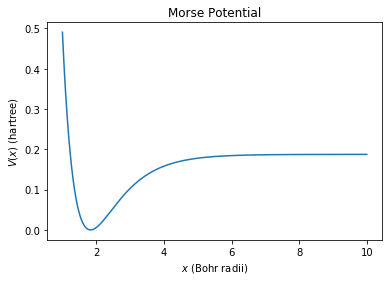

In [14]:
# sanity check that the Morse oscillator looks like as expected
xs = np.linspace(1, 10, 1000)
plt.plot(xs, V(xs))
plt.title(r'Morse Potential')
plt.ylabel(r'$V(x)$ (hartree)')
plt.xlabel(r'$x$ (Bohr radii)')
plt.show()

Now that we have sorted out units and have a function for the Morse oscillator, we can calculate the Hessian. First, the gradient is easily seen to be 
$$
\frac{\partial U_N(\mathbf x)}{\partial x_n} = \frac m{\beta_N^2\hbar^2}(-x_{n+1}+2x_n-x_{n-1}) + \frac{\partial V(x_n)}{\partial x_n}.
$$

Similarly, the Hessian can be calculated, 
$$
\frac{\partial^2 U_N(\mathbf x)}{\partial x_n\partial x_j} = 
\frac m{\beta_N^2\hbar^2}(-\delta_{n+1,j}+2\delta_{n,j}-\delta_{n-1,j})
+ 
\delta_{n,j}\frac{\partial^2 V(x_n)}{\partial x_n^2}.
$$
where, as usual, $\delta_{nj}$ is the Kronecker delta function. 

Assuming the Morse potential, it is also easily to calculate the second derivative thereof, via repeated differentiation,
$$
V''(x) = 2D_e\alpha^2e^{-\alpha(x-x_e)}(2e^{-\alpha(x-x_e)}-1).
$$

As described in the question, we are expanding about the bottom of the Morse oscillator, so we evaluate at $x=x_e$ and Taylor expand $U_N(x)\approx\frac 12x^THx$.

In [33]:
# V''(x) as found above
# we are expanding about the *minimum* => don't need as function
# Vpp(x) = lambda x: 2*De*α*α*np.exp(-α(x-xe))*(2*np.exp(-α*(x-xe))-1)
# Vpp(x_e) = 2Dα²

# assuming room temperature, T=293 K
β = 1/9.2787578809e-4 # 1/Eh

# TODO do this faster by adding np.eye, etc? If I have time

# I will write the Hessian as a function of N and x
# TODO check for overflow or cancellation errors! Prefactor seems big
def Hij(i,j,N):
    """
    returns the value of the N by N Hessian matrix ∇U at index i,j
    evaluated at x=x_e (i.e. minimum of Morse potential)
    
    helper function for hessian function, below
    :param: i row index
    :param: j column index
    :param: size of matrix (number of beads)
    :return: $H_{ij}$, value of H at index i,j 
    """
    if i==j:
        return 2*m*N*N/β/β+2*De*α*α
    if (i+1)%N==j: # mod N to ensure PBCs
        return -m*N*N/β/β
    if (i-1)%N==j:
        return -m*N*N/β/β
    else:
        return 0

def hessian(N):
    """
    returns the Hessian of size N
    """
    H = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            H[i,j] = Hij(i,j,N)
    return H
    
# print small example, looks fine 
print(hessian(4))

[[ 0.5485753  -0.02380566  0.         -0.02380566]
 [-0.02380566  0.5485753  -0.02380566  0.        ]
 [ 0.         -0.02380566  0.5485753  -0.02380566]
 [-0.02380566  0.         -0.02380566  0.5485753 ]]


---

b) Calculate the eigenvalues and eigenvectors of this matrix using 
```
evals, U = numpy.linalg.eigh(H)
```
We use eigh instead of eig because our matrix is hermitian (actually symmetric). If you want, you can check that the eigenvalues are in agreement with the Hückel cyclic alkene formula. The eigenvalues will be stored as a vector and the eigenvectors as a matrix. Show that the eigenvectors are stored in the columns by printing $U^THU$ and checking if the result is the diagonal matrix with the eigenvalues along the diagonal.

---

## Solution

In [48]:
# select some N 
N = 16
H = hessian(N)

evals, U = np.linalg.eigh(H)
UHU = (U.T @ H) @ U # U^THU
# If the following line returns True, then they are the same 
# up to the tolerance
print(np.all(np.abs(UHU-np.diag(evals))<=1e-10))

True


TODO also check the Hückel cyclic alkene formula (not familiar with this -- Look it up!)

---

c) We use the eigenvectors to define a set of normal modes for our system. Check (numerically) that for any path-integral configuration, $\mathbf x$, that $x^THx = \sum_k \lambda_kq_k^2$ where $\lambda_k$ are the eigenvalues and $\mathbf q = U^T(\mathbf x-x_e)$

---

## Solution

Since this is a numerical "proof," I assume that "for any path-integral configuration," we really mean an arbitrary configuration. 

In [145]:
# check for random values between zero and one 

x = np.random.rand(N)

xHx = x.T @ H @ x
print(xHx)

rhs = 0 # rhs of the expression, which should equal xHx
q = U.T @ x
for i in range(N):
    rhs += evals[i] * q[i] * q[i]
print(rhs)

3.986542572938772
3.986542572938777


_NOTE:_ I only got this to work by removing the $x_e$ in the definition of $\mathbf q$. I am not sure why $x_e$ is there in the first place.

TODO check other values when I have time

---

d) TODO

---

## Solution

TODO

---

e) TODO

---

## Solution

TODO

---

f) TODO

---

## Solution

TODO

---

g) TODO

---

## Solution

TODO

---